# Calculate the distorsion polynomial coefficients

Determines a common model for all test inputs
Outputs the model coefficients

In [1]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
import targets
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask, scaleLayout
from smdtLibs import utils, drawUtils
from astropy.modeling import models, fitting

from DistortionUtil import calcDistortionCoef

from Test_Input1 import Test_Inputs

# from Test_InputM53 import Test_Inputs

In [2]:
try:
    %load_ext nb_black
except:
    print("Ignore extension nb_black")
    pass

<IPython.core.display.Javascript object>

In [3]:
logging.disable()

<IPython.core.display.Javascript object>

## Read the config file and the parameter file

In [4]:
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)

<IPython.core.display.Javascript object>

## The mask layout

In [5]:
layout = MaskLayouts["deimos"]
guiderLayout = GuiderFOVs["deimos"]
layoutMM = scaleLayout(layout, utils.AS2MM, 0, -targets.ZPT_YM)
guiderLayoutMM = scaleLayout(guiderLayout, utils.AS2MM, 0, -targets.ZPT_YM)

<IPython.core.display.Javascript object>

In [6]:
def coeffNames(prefix, n):
    """
    Generates coefficient names
    """
    out = [prefix + "00"]
    out.extend([f"{prefix}x{i}y0" for i in range(1, n + 1)])
    out.extend([f"{prefix}x0y{i}" for i in range(1, n + 1)])
    for y in range(1, n):
        for x in range(1, n - y + 1):
            out.append(f"{prefix}x{x}y{y}")
    return out

<IPython.core.display.Javascript object>

In [7]:
# Determines distortion coefficients for enabled input files.
coeffs = []

keys = Test_Inputs.keys()
keys = sorted(keys, key=lambda x: Test_Inputs[x][3])

<IPython.core.display.Javascript object>

In [8]:
len(Test_Inputs)

13

<IPython.core.display.Javascript object>

In [13]:
for k in keys:
    info = Test_Inputs.get(k)
    (input_fname, input_RA, input_DEC, fieldPA, hourAngle, enabled) = info
    if not enabled:
        continue
    print(k)
    try:
        mdf, xfit, yfit, xres, yres = calcDistortionCoef(info, config, layout, 1)
    except Exception as e:
        print(k, "failed", e)
        continue

    a = [
        k,
        mdf.maskblu.RefWave[0],
        hourAngle,
        fieldPA,
        xres,
        yres,
    ]  # Reference wavelenght
    # XFit parameters (15)
    pRa, pDec, paDeg = mdf.getPNTCenter()
    a.extend((pRa, pDec))
    a.extend(xfit.parameters)
    # YFit parameters (15)
    a.extend(yfit.parameters)
    coeffs.append(a)
    # print(", ".join([f"{x}" for x in a]))

dec0Pa0
dec0Pa0 failed markInside() takes 1 positional argument but 2 were given
dec0Pa15
dec0Pa15 failed markInside() takes 1 positional argument but 2 were given
dec0Pa30
dec0Pa30 failed markInside() takes 1 positional argument but 2 were given
dec0Pa45
dec0Pa45 failed markInside() takes 1 positional argument but 2 were given
dec0Pa60
dec0Pa60 failed markInside() takes 1 positional argument but 2 were given
dec0Pa75
dec0Pa75 failed markInside() takes 1 positional argument but 2 were given
dec0Pa90
dec0Pa90 failed markInside() takes 1 positional argument but 2 were given
dec0Pa105
dec0Pa105 failed markInside() takes 1 positional argument but 2 were given
dec0Pa120
dec0Pa120 failed markInside() takes 1 positional argument but 2 were given
dec0Pa135
dec0Pa135 failed markInside() takes 1 positional argument but 2 were given
dec0Pa150
dec0Pa150 failed markInside() takes 1 positional argument but 2 were given
dec0Pa165
dec0Pa165 failed markInside() takes 1 positional argument but 2 were gi

<IPython.core.display.Javascript object>

In [10]:
#
# Outputs results
#
colNames = ["Name", "RefWave", "HA", "PA", "Xres", "Yres", "PRA", "PDEC"]
colNames.extend(coeffNames("X_", 4))
colNames.extend(coeffNames("Y_", 4))

coeffsDf = pd.DataFrame(coeffs, columns=colNames)
coeffsDf[["Name", "RefWave", "HA", "PA", "Xres", "Yres", "PRA", "PDEC", "X_00", "Y_00"]]

,Name,RefWave,HA,PA,Xres,Yres,PRA,PDEC,X_00,Y_00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


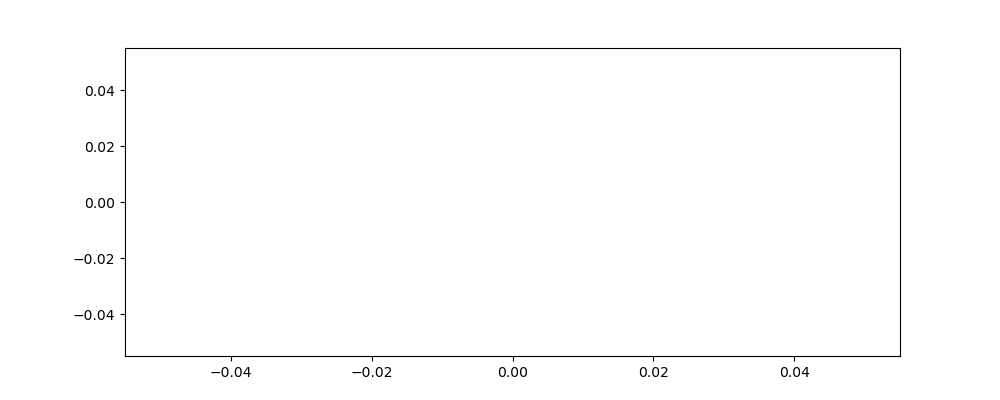

<IPython.core.display.Javascript object>

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(coeffsDf.X_00, coeffsDf.Y_00, ".")
# plt.plot((coeffsDf.PRA - cenRA) * 3600, (coeffsDf.PDEC - cenDEC) * 3600, "+")
# plt.plot(coeffsDf.PRA, coeffsDf.PDEC, "+")

In [12]:
#
# Averages the coefficients
#
startidx = 8
xs = [f"{coeffsDf[cn].mean()}" for cn in colNames[startidx : startidx + 15]]
ys = [f"{coeffsDf[cn].mean()}" for cn in colNames[startidx + 15 :]]

with open("coeffs.dat", "w") as fh:
    print('distortionXCoeffs = "', ", ".join(xs), '"', file=fh)
    print('distortionYCoeffs = "', ", ".join(ys), '"', file=fh)
#
# The output should be copied to smdt.cfg
#
!cat coeffs.dat

distortionXCoeffs = " nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan "
distortionYCoeffs = " nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan "


<IPython.core.display.Javascript object>